In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
gridSize = 100
z_dim = 5

bs = 256

In [3]:
import torch.nn.functional as F
   
class AttentionVAE(nn.Module):
    def __init__(self, sample_size, grid_size, cond_size, encoder_layer_sizes, latent_size, decoder_layer_sizes):
        super(AttentionVAE, self).__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        
        self.latent_size = latent_size
        self.condNN = CondNN(sample_size, grid_size, cond_size)
        self.encoder = Encoder(sample_size + cond_size, encoder_layer_sizes, latent_size)
        self.decoder = Decoder(latent_size + cond_size, decoder_layer_sizes, sample_size)

    def condnn(self,startend, occ):
        return self.condNN(startend, occ)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

#     @torch.jit.export
    def forward(self, x, startend, occ):
        c, _ = self.condnn(startend, occ)
        mu, logvar = self.encode(torch.cat((x, c), dim=-1))
        z = self.reparameterize(mu, logvar)
        self.inference(startend, occ, torch.tensor(1))
        return self.decode(torch.cat((z, c), dim=-1)), mu, logvar
    
    def inference(self, startend, occ, num_viz):
        c, alpha = self.condnn(startend, occ)
        z = torch.randn(num_viz, self.latent_size, device = c.device)
        return self.decode(torch.cat((z, c), dim=-1)), alpha
    
class Encoder(nn.Module):
    def __init__(self, input_size, layer_sizes, latent_size):
        super(Encoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))

        self.sequential = nn.Sequential(*modules)
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):
        x = self.sequential(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes, sample_size):
        super(Decoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))
        modules.append(nn.Linear(layer_sizes[-1], sample_size))
        
        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)


class CondNN(nn.Module):
    def __init__(self, sampleSize, gridSize, outSize, encoder_dim=48, condition_dim=12, attention_dim=48):
        super(CondNN, self).__init__()
        self.CnnEncoder = CnnEncoder(gridSize)
        self.Attention = Attention(encoder_dim + 2, condition_dim, attention_dim) # + 2 for position
        self.fc1 = nn.Linear(attention_dim + 2 + condition_dim, outSize)

    def forward(self, startend, occ):
        encoder_out = self.CnnEncoder(occ)
        attention_weighted_encoding, alpha = self.Attention(encoder_out, startend)
        x = torch.cat((attention_weighted_encoding, startend), dim=-1)
        x = self.fc1(x)
        return x, alpha

class CnnEncoder(nn.Module):
    def __init__(self, gridSize, encoded_image_size=11):
        super(CnnEncoder, self).__init__()
        self.gridSize = gridSize
        self.encoded_image_size = encoded_image_size
        self.cnn = nn.Sequential(
                    nn.Conv2d(1, 6, 5, padding=(2,2)),
                    nn.MaxPool2d(3,3),
                    nn.Conv2d(6, 16, 5, padding=(2,2)),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(16, 48, 5, padding=(2,2)),
                    nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)))
            
    def forward(self, images):
        out = self.cnn(images)
        out = out.permute(0, 2, 3, 1) # (batch_size, encoded_image_size, encoded_image_size, 48)
        return out
            
class Attention(nn.Module):
    def __init__(self, encoder_dim, condition_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.condition_att = nn.Linear(condition_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.position = self.initPosition()
    
    def initPosition(self):
        x = np.linspace(0, 10, 11, dtype='float32')
        y = np.linspace(0, 10, 11, dtype='float32')
        xv, yv = np.meshgrid(x,y)
        xv, yv = xv.reshape((1,-1, 1)), yv.reshape((1,-1, 1))
        position = torch.from_numpy(np.concatenate((xv, yv), axis = 2))
        
        return position
        
        
    def forward(self, encoder_out, condition):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        self.position = self.position.to(encoder_out.device)
        self.position = self.position.expand(batch_size, self.position.shape[1], self.position.shape[2])
        encoder_out = torch.cat((encoder_out, self.position), dim = 2)
        
        att1 = self.encoder_att(encoder_out)
        att2 = self.condition_att(condition)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
            
        return attention_weighted_encoding, alpha

In [4]:
torch.cuda.empty_cache()

model = AttentionVAE(sample_size = X_dim, 
                  grid_size = gridSize, 
                  cond_size = 21,
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load('checkpoints/attention.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model.eval()

AttentionVAE(
  (condNN): CondNN(
    (CnnEncoder): CnnEncoder(
      (cnn): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): AdaptiveAvgPool2d(output_size=(11, 11))
      )
    )
    (Attention): Attention(
      (encoder_att): Linear(in_features=50, out_features=48, bias=True)
      (condition_att): Linear(in_features=12, out_features=48, bias=True)
      (full_att): Linear(in_features=48, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax(dim=1)
    )
    (fc1): Linear(in_features=62, out_features=21, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Line

In [5]:
from data.AttentionDataset import AttentionDataset

test_loader = DataLoader(AttentionDataset(np_file_data = 'data/NarrowPassage/narrowDataOcc100.npz',
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = False),
                          batch_size = bs, shuffle=True, drop_last = True)

8712


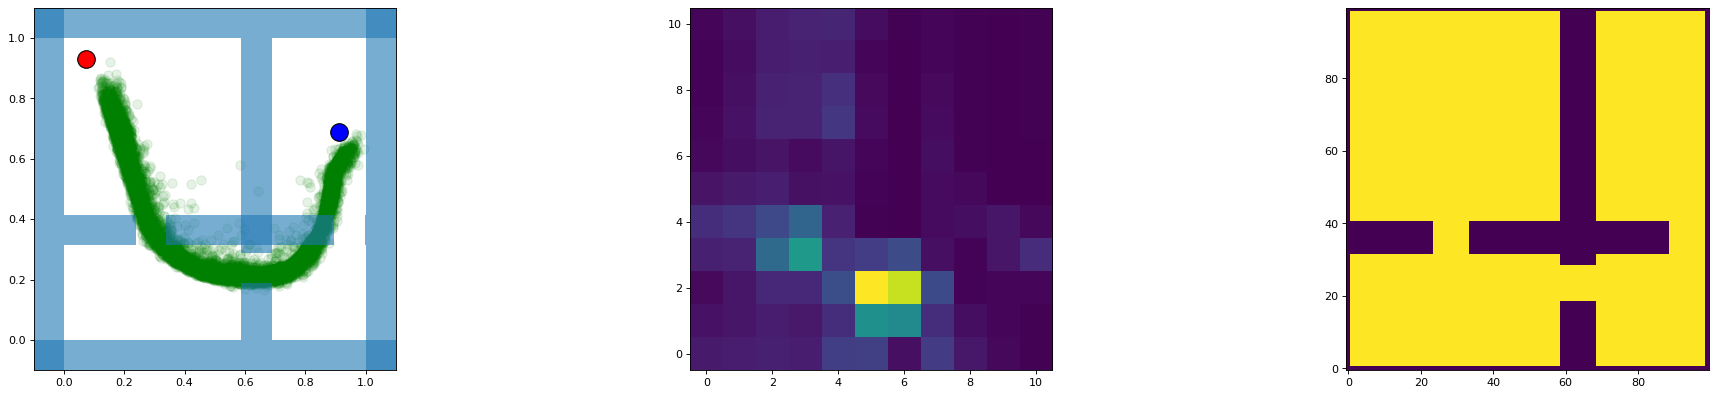

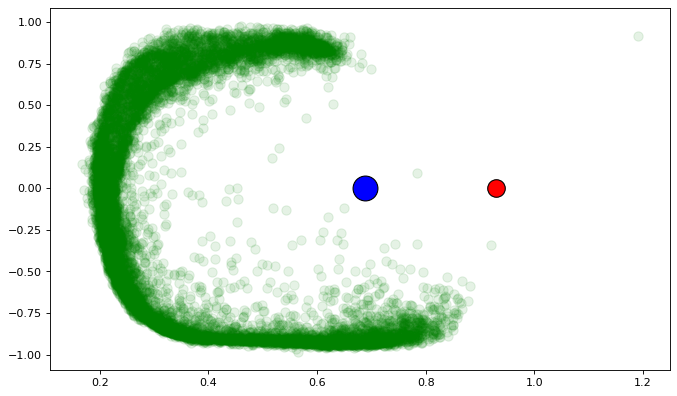

In [6]:
test_data = test_loader.dataset
viz_idx =   torch.randint(0,len(test_data),[1]).item()  
viz_idx = 8712
print(viz_idx)

_, con, startend, occ = test_data[viz_idx]
startend, occ = torch.tensor(startend), torch.unsqueeze(torch.tensor(occ), 0)

model.eval()
y_viz = torch.randn(1,6).to(device)
with torch.no_grad():
    for i in range(0, 40):
        num_viz = 256
        y_viz_p, alpha = model.inference(startend.expand(num_viz, X_dim * 2).to(device), 
                                occ.expand(num_viz, 1, gridSize, gridSize).to(device), num_viz)
        torch.cuda.empty_cache()
        y_viz = torch.cat((y_viz_p, y_viz), dim = 0)

y_viz=y_viz.cpu().detach().numpy()
occ=occ.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed, plotSampleAttention, gap2obs

torch.cuda.empty_cache()

startend = startend.cpu().detach().numpy()
occ = occ[0].reshape(100,100)
a = alpha[0].reshape(11,11)
a = a.cpu().detach().numpy()

plotSampleAttention(y_viz, con, occ, a)
plotSpeed(y_viz, con)

In [7]:
def con2obs(con):
    dw = 0.1
    dimW = 3
    gap1 = con[0:3]
    gap2 = con[3:6]
    gap3 = con[6:9]

    obs1 = [0, gap1[1] - dw, -0.5, gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0] - dw, 0, -0.5, gap2[0], gap2[1], 1.5]
    obs3 = [gap2[0] - dw, gap2[1] + dw, -0.5, gap2[0], 1, 1.5]
    obs4 = [gap1[0] + dw, gap1[1] - dw, -0.5, gap3[0], gap1[1], 1.5]
    obs5 = [gap3[0] + dw, gap1[1] - dw, -0.5, 1, gap1[1], 1.5]
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    return obs, dimW

import matplotlib.patches as patches
def pltObs(obs, dimW):
    fig1 = plt.figure(figsize=(30, 6), dpi=80)
    ax1 = fig1.add_subplot(131, aspect='equal')
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        ax1.add_patch(
            patches.Rectangle(
                (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
                obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
                obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
                alpha=0.6
            ))
    plt.show()

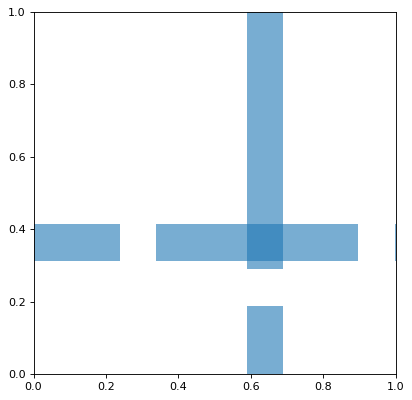

In [8]:
obs, dimW = con2obs(con)
pltObs(obs, dimW)

In [9]:
import fcl

def obs2fcl(obs, dimW):
    obs_fcl = []
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        width = obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW]
        height = obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1]
    #     width = height = 1
        ob = fcl.Box(width, height, 1)
        x = obs[i * 2 * dimW] + width/2
        y = obs[i * 2 * dimW + 1] + height/2
    #     x = y = 0
        T = np.array([x, y, 0])
        t = fcl.Transform(T)
        co = fcl.CollisionObject(ob, t)
        obs_fcl.append(co)
#         print("x: ", x, " y: ", y, " width: ", width, " height: ", height)

    obs_manager = fcl.DynamicAABBTreeCollisionManager()
    obs_manager.registerObjects(obs_fcl)
    obs_manager.setup()
    return obs_manager

In [10]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")
        
from utils.NarrowPassage import gap2obs
def plt_ompl_result(condition, start, goal, path, collisionchecker, spaceinfo, planner):
    fig1 = plt.figure(figsize=(10, 6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')
    obs, dimW = gap2obs(condition)
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        ax1.add_patch(
            patches.Rectangle(
                (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
                obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
                obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
                alpha=0.6
            ))
#         ax1.add_patch(
#             patches.Rectangle(
#                 (1-obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
#                 obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
#                 obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
#                 alpha=0.6
#             ))
    gridSize = 11
    
    plannerdata = ob.PlannerData(spaceinfo)
    planner.getPlannerData(plannerdata)
    print("num edges: ", plannerdata.numEdges())
    print("num vertices: ", plannerdata.numVertices())
    num_ver = plannerdata.numVertices()
    num_edge = plannerdata.numEdges()
    if num_edge > 3000:
        print("too much edges")
        edge_vis = False
    else:
        edge_vis = True
    for i in range(0, num_ver):
        plt.scatter( plannerdata.getVertex(i).getState().getX(), plannerdata.getVertex(i).getState().getY(), color="green", s=50, edgecolors='black')  # vertice
        if edge_vis:
            for j in range(0, num_ver):
                if plannerdata.edgeExists(i, j):
                    plt.plot([plannerdata.getVertex(i).getState().getX(), plannerdata.getVertex(j).getState().getX()], [plannerdata.getVertex(i).getState().getY(), plannerdata.getVertex(j).getState().getY()], color='gray')
                
    path.interpolate()
    states = path.getStates()
    for state in states:
        plt.scatter(state.getX(), state.getY(), color="green", s=250, edgecolors='black')  # path
#     for state in collisionchecker.states_ok:
#         plt.scatter(state[0], state[1], color="green", s=100, edgecolors='green')  # free sample
#     for state in collisionchecker.states_bad:
#         plt.scatter(state[0], state[1], color="red", s=100, edgecolors='red')  # collision sample
    plt.scatter(start().getX(), start().getY(), color="blue", s=250, edgecolors='black')  # init
    plt.scatter(goal().getX(), goal().getY(), color="red", s=250, edgecolors='black')  # goal
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [11]:
class MyValidStateSampler(ob.ValidStateSampler):
    def __init__(self, si, cvae_samples):
        super(MyValidStateSampler, self).__init__(si)
        print("my valid state sampler")
        self.name_ = "my sampler"
        self.cvae_samples = cvae_samples
        self.cvae_num = cvae_samples.shape[0]
        print("cvae_num", self.cvae_num)
        self.i = 0
        self.random_count = 0
        self.rng_ = ou.RNG()
        
#     def __call__(self, i): 
#         return self
        
    def sample(self, state):
        chance = self.rng_.uniformReal(0, 1)
#         print("sample")
        
        if chance < 0.4:
            x = self.cvae_samples[self.i, 0]
            y = self.cvae_samples[self.i, 1]
            self. i += 1
            if self.i == self.cvae_num:
                self.i = 0
#             print("cvae: ", self.i)
        else:
            x = self.rng_.uniformReal(0, 1)
            y = self.rng_.uniformReal(0, 1)
            self.random_count += 1
#             print("random: ", self.random_count)
        state.setX(float(x))
        state.setY(float(y))
        return True
    
class MyStateSampler(ob.StateSampler):
    def __init__(self, space, cvae_samples):
        super(MyStateSampler, self).__init__(space)
        self.cvae_samples = cvae_samples
        self.cvae_num = cvae_samples.shape[0]
        self.i = 0
        self.rng_ = ou.RNG()
#         print("my state sampler")
#     def __call__(self, i): 
#         return self
        
    def sampleUniform(self, state):
        chance = self.rng_.uniformReal(0, 1)
#         print("my sample uniform")
        
        if chance < 0.35:
            x = self.cvae_samples[self.i, 0]
            y = self.cvae_samples[self.i, 1]
            self. i += 1
            if self.i == self.cvae_num:
                self.i = 0
#             print("here ", self.i)
        else:
            x = self.rng_.uniformReal(0, 1)
            y = self.rng_.uniformReal(0, 1)
        state.setX(float(x))
        state.setY(float(y))
        return True
    
    def sampleUniformNear(self, state, nearstate, dis):
        print("sample uniform near")
        self.sampleUniform(state)
        
    def sampleGaussian(self, state, nearstate, dis):
        print("sample guassian")
        self.sampleUniform(state)
        
# return an instance of my sampler
def allocMyValidStateSampler(si):
    return MyValidStateSampler(si, y_viz)

def allocMyStateSampler(space):
    return MyStateSampler(space, y_viz)

class ValidityChecker(ob.StateValidityChecker):
    def __init__(self,  si, fcl_manager, space):
        super(ValidityChecker, self).__init__(si)
        self.space = space
        self.fcl_manager = fcl_manager
        self.count = 0
        self.collision_count = 0
        self.states_ok = []
        self.states_bad = []
        # Returns whether the given state's position overlaps the
        # circular obstacle
    def isValid(self, state):
#         print("collision")
        sample = np.array([state.getX(), state.getY(), 0])
#         sample = np.array([state().getX(), state().getY(), state().getYaw()])
        req = fcl.CollisionRequest(num_max_contacts=100, enable_contact=True)
        rdata = fcl.CollisionData(request = req)

        cyl = fcl.Cylinder(0.01, 2)
        t = fcl.Transform(sample)
        agent = fcl.CollisionObject(cyl, t)

        self.fcl_manager.collide(agent, rdata, fcl.defaultCollisionCallback)
#         if(rdata.result.is_collision):
#             print("state: ", sample, " collision: ", rdata.result.is_collision)
#         print ('Collision between manager 1 and agent?: {}'.format(rdata.result.is_collision))
#         print( 'Contacts:')
#         for c in rdata.result.contacts:
#             print( '\tO1: {}, O2: {}'.format(c.o1, c.o2))
        self.count += 1
        if(rdata.result.is_collision):
            self.collision_count += 1
#             self.states_bad.append(sample)
#         else:
#             self.states_ok.append(sample)
        return not rdata.result.is_collision

In [14]:
# rrt_star
def roll_out(times, solve_times):
    for solve_time in solve_times:
        sucess = 0
        total = 0
        total_length = 0
        total_collision_detection = 0
        total_collision = 0

        for i in range(0,times):
            space = ob.SE2StateSpace()
            # set lower and upper bounds
            bounds = ob.RealVectorBounds(2)
            bounds.setLow(0)
            bounds.setHigh(1)
            space.setBounds(bounds)
            # construct an instance of space information from this state space
            si = ob.SpaceInformation(space)
            # set state validity checking for this space
            obs_manager = obs2fcl(obs, dimW)
            mychecker = ValidityChecker(si, obs_manager, space)
            si.setStateValidityChecker(mychecker)

            si.setStateValidityCheckingResolution(0.03)
            # si.setup()
            # create a random start state
            start = ob.State(space)
            start.random()
            start().setX(float(startend[0]))
            start().setY(float(startend[1]))
            # create a random goal state
            goal = ob.State(space)
            goal.random()
            goal().setX(float(startend[6]))
            goal().setY(float(startend[7]))
            # create a problem instance
            pdef = ob.ProblemDefinition(si)
            pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))
            # set the start and goal states
            pdef.setStartAndGoalStates(start, goal)
        #     si.setValidStateSamplerAllocator (ob.ValidStateSamplerAllocator(allocMyValidStateSampler))
            si.getStateSpace().setStateSamplerAllocator(ob.StateSamplerAllocator(allocMyStateSampler))
            optimizingPlanner = allocatePlanner(si, 'rrtstar')
            # planner = og.RRTConnect(si)
            # set the problem we are trying to solve for the planner
            optimizingPlanner.setProblemDefinition(pdef)
            # perform setup steps for the planner
#             optimizingPlanner.setRewireFactor(100)
            optimizingPlanner.setRange(0.06)
            optimizingPlanner.setKNearest(True)
            optimizingPlanner.setup()
            
#             print("r_rrt_", si.getSpaceMeasure())
#             print("getKNearest", optimizingPlanner.getKNearest())
#             print("getRewireFactor", optimizingPlanner.getRewireFactor())
        #     print("range", optimizingPlanner.getRange())
            # print the settings for this space
            # print(si.settings())
            # print the problem settings
            # print(pdef)
            # attempt to solve the problem within one second of planning time
            solved = optimizingPlanner.solve(solve_time)
        #     print("collision detection: ", mychecker.count)
            total_collision_detection += mychecker.count
        #     print("collision num: ", mychecker.collision_count)
            total_collision += mychecker.collision_count

            total += 1
            if solved.asString() == 'Exact solution':
                # get the goal representation from the problem definition (not the same as the goal state)
                # and inquire about the found path
                path = pdef.getSolutionPath()
                if path:
        #             print("path length: ", pdef.getSolutionPath().length())
                    total_length += pdef.getSolutionPath().length()
            #     print("Found solution:\n%s" % path)
#                     plt_ompl_result(con, start, goal,path, mychecker, si, optimizingPlanner)
                sucess += 1
#             else:
        #         print("No solution found")
        print("solve_time: ", solve_time)
        print("success rate: ", sucess/total)
#         print("average collision detection:", total_collision_detection/total)
#         print("average collision", total_collision/total)
        if sucess > 0:
            print("average length: ", total_length/sucess)
        else:
            print("average length none")
    
# roll_out(100, [0.02, 0.05, 0.08, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3])
roll_out(5, [0.5])

solve_time:  0.5
success rate:  1.0
average length:  2.9391532439515884


In [15]:
#  初次成功，调整range至0.06，success rate成功
roll_out(100, [0.02, 0.05, 0.08, 0.10, 0.15,0.2,0.25, 0.3,0.35,  0.4, 0.5, 0.6, 0.7, 0.8, 1])

solve_time:  0.02
success rate:  0.0
average length none
solve_time:  0.05
success rate:  0.01
average length:  3.5113069148350027
solve_time:  0.08
success rate:  0.17
average length:  3.242110442433819
solve_time:  0.1
success rate:  0.2
average length:  2.7527091682717844
solve_time:  0.15
success rate:  0.45
average length:  2.898589174763049
solve_time:  0.2
success rate:  0.68
average length:  2.9897857708154483
solve_time:  0.25
success rate:  0.66
average length:  2.9897067133282684
solve_time:  0.3
success rate:  0.78
average length:  2.9509394312176074
solve_time:  0.35
success rate:  0.86
average length:  2.9257797236447516
solve_time:  0.4
success rate:  0.86
average length:  2.8527798561122024
solve_time:  0.5
success rate:  0.94
average length:  2.940073673361725
solve_time:  0.6
success rate:  0.96
average length:  3.1693997620186516
solve_time:  0.7
success rate:  0.97
average length:  3.0127842347192195
solve_time:  0.8
success rate:  1.0
average length:  2.86514710911

In [132]:
# rrt_star dubins
sucess = 0
total = 0
total_length = 0
total_collision_detection = 0
total_collision = 0

for i in range(0,100):
    space = ob.DubinsStateSpace(0.05)
    # set lower and upper bounds
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0)
    bounds.setHigh(1)
    space.setBounds(bounds)
    # construct an instance of space information from this state space
    si = ob.SpaceInformation(space)
    # set state validity checking for this space
    obs_manager = obs2fcl(obs, dimW)
    mychecker = ValidityChecker(si, obs_manager, space)
    si.setStateValidityChecker(mychecker)

    si.setStateValidityCheckingResolution(0.03)
    # si.setup()
    # create a random start state
    start = ob.State(space)
    start.random()
    start().setX(float(startend[0]))
    start().setY(float(startend[1]))
    start().setYaw(float(startend[2]))
    # create a random goal state
    goal = ob.State(space)
    goal.random()
    goal().setX(float(startend[6]))
    goal().setY(float(startend[7]))
    goal().setYaw(float(startend[8]))
    # create a problem instance
    pdef = ob.ProblemDefinition(si)
    pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))
    # set the start and goal states
    pdef.setStartAndGoalStates(start, goal)
    si.setValidStateSamplerAllocator (ob.ValidStateSamplerAllocator(allocMyValidStateSampler))
    si.getStateSpace().setStateSamplerAllocator(ob.StateSamplerAllocator(allocMyStateSampler))
    optimizingPlanner = allocatePlanner(si, 'rrtstar')
    # planner = og.RRTConnect(si)
    # set the problem we are trying to solve for the planner
    optimizingPlanner.setProblemDefinition(pdef)
    # perform setup steps for the planner
    optimizingPlanner.setup()

    # print the settings for this space
    # print(si.settings())
    # print the problem settings
    # print(pdef)
    # attempt to solve the problem within one second of planning time
    solved = optimizingPlanner.solve(0.1)
    print("collision detection: ", mychecker.count)
    total_collision_detection += mychecker.count
    print("collision num: ", mychecker.collision_count)
    total_collision += mychecker.collision_count
    
    total += 1
    if solved.asString() == 'Exact solution':
        # get the goal representation from the problem definition (not the same as the goal state)
        # and inquire about the found path
        path = pdef.getSolutionPath()
        if path:
            print("path length: ", pdef.getSolutionPath().length())
            total_length += pdef.getSolutionPath().length()
    #     print("Found solution:\n%s" % path)
#             plt_ompl_result(con, start, goal,path, mychecker, si, optimizingPlanner
        sucess += 1
    else:
        print("No solution found")

print("success rate: ", sucess/total)
print("average collision detection:", total_collision_detection/total)
print("average collision", total_collision/total)
print("average length: ", total_length/sucess)

collision detection:  3069
collision num:  564
No solution found
collision detection:  3597
collision num:  685
No solution found
collision detection:  3376
collision num:  574
path length:  1.7458349297756353
collision detection:  3298
collision num:  671
No solution found
collision detection:  3868
collision num:  712
No solution found
collision detection:  3188
collision num:  616
No solution found
collision detection:  2791
collision num:  542
No solution found
collision detection:  3305
collision num:  581
No solution found
collision detection:  3467
collision num:  663
No solution found
collision detection:  3305
collision num:  648
No solution found
collision detection:  3814
collision num:  697
No solution found
collision detection:  3080
collision num:  573
No solution found
collision detection:  2571
collision num:  399
No solution found
collision detection:  3336
collision num:  648
No solution found
collision detection:  3156
collision num:  600
No solution found
collision 

KeyboardInterrupt: 

my valid state sampler
cvae_num 10241
collision detection:  9318
collision num:  1105
path length:  3.3160347704469073
num edges:  3742
num vertices:  179
too much edges


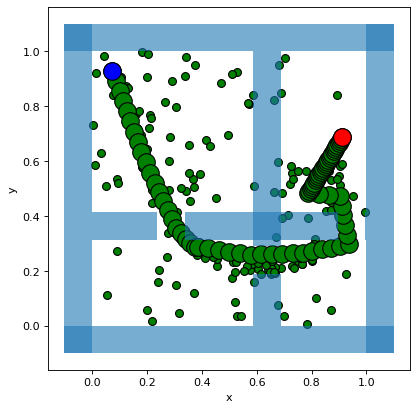

success rate:  1.0
average collision detection: 9318.0
average collision 1105.0
average length:  3.3160347704469073


In [17]:
# prm_star
sucess = 0
total = 0
total_length = 0
total_collision_detection = 0
total_collision = 0

for i in range(0, 1):
    space = ob.SE2StateSpace()
    # set lower and upper bounds
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0)
    bounds.setHigh(1)
    space.setBounds(bounds)
    # construct an instance of space information from this state space
    si = ob.SpaceInformation(space)
    # set state validity checking for this space
    obs_manager = obs2fcl(obs, dimW)
    mychecker = ValidityChecker(si, obs_manager, space)
    si.setStateValidityChecker(mychecker)



    si.setStateValidityCheckingResolution(0.03)
    # si.setup()
    # create a random start state
    start = ob.State(space)
    start.random()
    start().setX(float(startend[0]))
    start().setY(float(startend[1]))
    # create a random goal state
    goal = ob.State(space)
    goal.random()
    goal().setX(float(startend[6]))
    goal().setY(float(startend[7]))
    # create a problem instance
    pdef = ob.ProblemDefinition(si)
    pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))
    # set the start and goal states
    pdef.setStartAndGoalStates(start, goal)
    si.setValidStateSamplerAllocator (ob.ValidStateSamplerAllocator(allocMyValidStateSampler))
    optimizingPlanner = allocatePlanner(si, 'prmstar')
    # planner = og.RRTConnect(si)
    # set the problem we are trying to solve for the planner
    optimizingPlanner.setProblemDefinition(pdef)
    # perform setup steps for the planner
    optimizingPlanner.setup()

    # print the settings for this space
    # print(si.settings())
    # print the problem settings
    # print(pdef)
    # attempt to solve the problem within one second of planning time
    solved = optimizingPlanner.solve(0.1)
    print("collision detection: ", mychecker.count)
    total_collision_detection += mychecker.count
    print("collision num: ", mychecker.collision_count)
    total_collision += mychecker.collision_count
    
    total += 1
    if solved.asString() == 'Exact solution':
        # get the goal representation from the problem definition (not the same as the goal state)
        # and inquire about the found path
        path = pdef.getSolutionPath()
        if path:
            print("path length: ", pdef.getSolutionPath().length())
            total_length += pdef.getSolutionPath().length()
    #     print("Found solution:\n%s" % path)
            plt_ompl_result(con, start, goal,path, mychecker, si, optimizingPlanner)
        sucess += 1
    else:
        print("No solution found")

print("success rate: ", sucess/total)
print("average collision detection:", total_collision_detection/total)
print("average collision", total_collision/total)
print("average length: ", total_length/sucess)

In [18]:
plt_ompl_result(con, start, goal,path, mychecker)

TypeError: plt_ompl_result() missing 2 required positional arguments: 'spaceinfo' and 'planner'

collision detection:  2427
collision num:  278
path length:  1.6922709163926375
num edges:  484
num vertices:  502


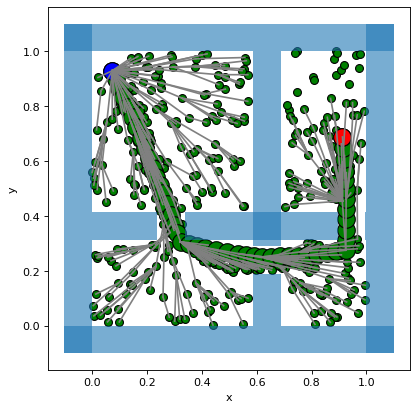

collision detection:  2571
collision num:  330
path length:  1.666026296655854
num edges:  485
num vertices:  502


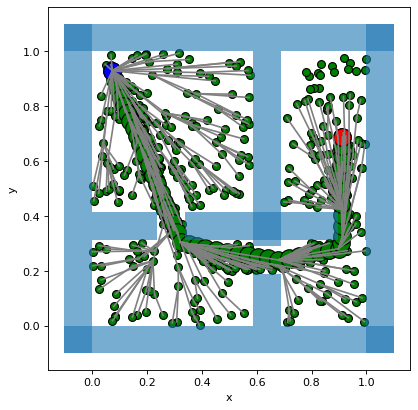

collision detection:  2483
collision num:  308
path length:  1.6813511634164888
num edges:  484
num vertices:  502


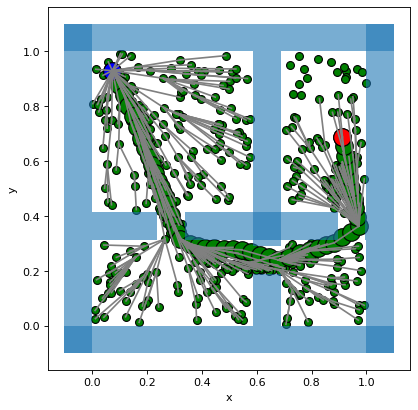

collision detection:  2259
collision num:  239
path length:  1.6771512595929732
num edges:  489
num vertices:  502


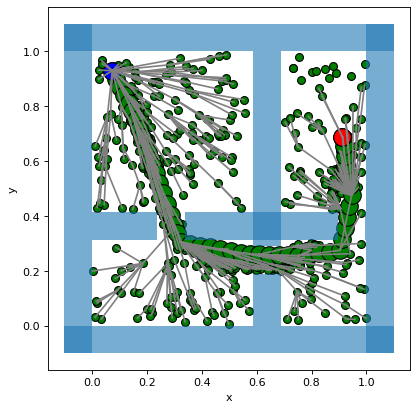

collision detection:  2251
collision num:  261
No solution found
collision detection:  2376
collision num:  305
No solution found
collision detection:  2421
collision num:  288
path length:  1.6723022528911955
num edges:  482
num vertices:  502


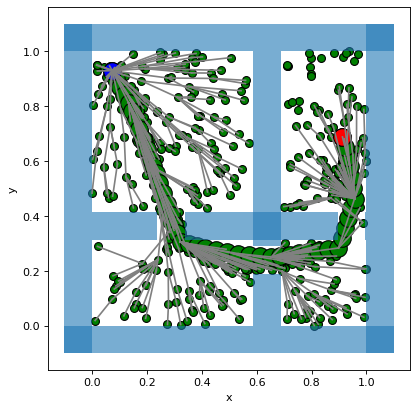

collision detection:  2497
collision num:  314
path length:  1.6493184976888555
num edges:  482
num vertices:  502


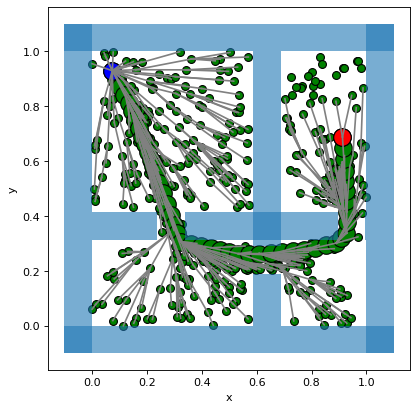

collision detection:  2340
collision num:  258
path length:  1.6671102583479658
num edges:  490
num vertices:  502


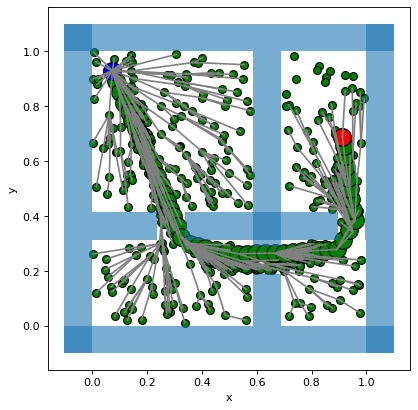

collision detection:  2498
collision num:  295
path length:  1.684971090811349
num edges:  486
num vertices:  502


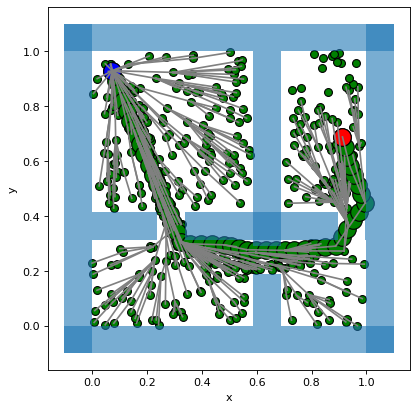

success rate:  0.8
average collision detection: 2412.3
average collision:  287.6
average length:  1.673812716974665


In [71]:
# fmt_star
sucess = 0
total = 0
total_length = 0
total_collision_detection = 0
total_collision = 0

for i in range(0,10):
#     state space
    space = ob.SE2StateSpace()
    # set lower and upper bounds
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0)
    bounds.setHigh(1)
    space.setBounds(bounds)
    # construct an instance of space information from this state space
    si = ob.SpaceInformation(space)
    # set state validity checking for this space
    obs_manager = obs2fcl(obs, dimW)
    mychecker = ValidityChecker(si, obs_manager, space)
    si.setStateValidityChecker(mychecker)
    si.setStateValidityCheckingResolution(0.03)
    si.getStateSpace().setStateSamplerAllocator(ob.StateSamplerAllocator(allocMyStateSampler))
    si.setup()

# 起点终点
    start = ob.State(space)
    start.random()
    start().setX(float(startend[0]))
    start().setY(float(startend[1]))
    # create a random goal state
    goal = ob.State(space)
    goal.random()
    goal().setX(float(startend[6]))
    goal().setY(float(startend[7]))
    # create a problem instance
    pdef = ob.ProblemDefinition(si)
    pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))
    # set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    optimizingPlanner = allocatePlanner(si, 'fmtstar')
#     限制采1000个点
    optimizingPlanner.setNumSamples(500)
    optimizingPlanner.setExtendedFMT(False)
#     optimizingPlanner.setFreeSpaceVolume(1)
#     optimizingPlanner.setRadiusMultiplier(5)
    # set the problem we are trying to solve for the planner
    optimizingPlanner.setProblemDefinition(pdef)
    # perform setup steps for the planner
    optimizingPlanner.setup()
    
    solved = optimizingPlanner.solve(0.08)
    print("collision detection: ", mychecker.count)
    total_collision_detection += mychecker.count
    print("collision num: ", mychecker.collision_count)
    total_collision += mychecker.collision_count

    total += 1
    if solved.asString() == 'Exact solution':
#     print(solved)
#     if solved:
        # get the goal representation from the problem definition (not the same as the goal state)
        # and inquire about the found path
        path = pdef.getSolutionPath()
        if path:
            print("path length: ", pdef.getSolutionPath().length())
            total_length += pdef.getSolutionPath().length()
    #     print("Found solution:\n%s" % path)
            plt_ompl_result(con, start, goal,path, mychecker, si, optimizingPlanner)
        sucess += 1
    else:
        print("No solution found")

from termcolor import colored
print(colored("success rate: ", 'red'), sucess/total)
print(colored("average collision detection:", 'red'), total_collision_detection/total)
print(colored("average collision: ", "red"), total_collision/total)
if sucess > 0:
    print(colored("average length: ", "red"),  total_length/sucess)

num edges:  482
num vertices:  502


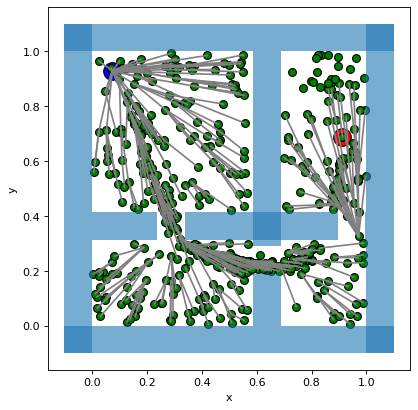

In [13]:
plannerdata = ob.PlannerData(si)
optimizingPlanner.getPlannerData(plannerdata)

print("num edges: ", plannerdata.numEdges())
print("num vertices: ", plannerdata.numVertices())

condition = con
fig1 = plt.figure(figsize=(10, 6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
obs, dimW = gap2obs(condition)
for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
    ax1.add_patch(
        patches.Rectangle(
            (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
            obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
            obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
            alpha=0.6
        ))
gridSize = 11

#     for state in collisionchecker.states_ok:
#         plt.scatter(state[0], state[1], color="green", s=100, edgecolors='green')  # free sample
#     for state in collisionchecker.states_bad:
#         plt.scatter(state[0], state[1], color="red", s=100, edgecolors='red')  # collision sample
plt.scatter(start().getX(), start().getY(), color="blue", s=250, edgecolors='black')  # init
plt.scatter(goal().getX(), goal().getY(), color="red", s=250, edgecolors='black')  # goal

num_ver = plannerdata.numVertices()
for i in range(0, num_ver):
    plt.scatter( plannerdata.getVertex(i).getState().getX(), plannerdata.getVertex(i).getState().getY(), color="green", s=50, edgecolors='black')  # vertice
    for j in range(i, num_ver):
        if plannerdata.edgeExists(i, j):
            plt.plot([plannerdata.getVertex(i).getState().getX(), plannerdata.getVertex(j).getState().getX()], [plannerdata.getVertex(i).getState().getY(), plannerdata.getVertex(j).getState().getY()], color='gray')
            
plt.xlabel('x')
plt.ylabel('y')
plt.show()